# Climate change analysis of hydrological data

In [1]:
# Imports
import numpy as np
import xarray as xr
import hvplot.xarray
import xclim

import xhydro as xh

While there is a huge variety of analyses that could be done to assess the impacts of climate change on hydrology, this notebook will go through some of the most common steps:

- Computing a list of relevant indicators over climatological periods
- Computing future deltas
- Computing ensemble statistics to assess future changes

<div class="alert alert-info"> <b>INFO</b>

Multiple functions in `xh.indicators` and `xh.cc` have been leveraged from the `xscen` library and made accessible to `xhydro` users. For more information on these function, it is recommended to look at:

- [compute_indicators](https://xscen.readthedocs.io/en/latest/notebooks/2_getting_started.html#Computing-indicators)
- [climatological_op](https://xscen.readthedocs.io/en/latest/notebooks/2_getting_started.html#Climatological-operations)
- [compute_deltas](https://xscen.readthedocs.io/en/latest/notebooks/2_getting_started.html#Computing-deltas)
- [ensemble_statistics](https://xscen.readthedocs.io/en/latest/notebooks/2_getting_started.html#Ensemble-statistics)

Also, more information on building custom indicators is also available [in the xclim documentation](https://xclim.readthedocs.io/en/latest/api.html#yaml-file-structure).

</div>

In [2]:
# This notebook will use data from the 2022 edition of the Hydrological Atlas of Southern Quebec, which can be accessed from the xhydro-testdata repository. 
# These consist of 10 simulations of the HYDROTEL hydrological model at 2 stations, driven by bias adjusted simulations from 1955 to 2100.

# FIXME: Replace with pooch
from glob import glob
from pathlib import Path
import os

files = sorted(glob(str(Path(os.getcwd()).parent.parent.parent / "xhydro-testdata" / "data" / "AtlasHydro2022" / "*.nc")))

ds_dict = {}
for i, f in enumerate(files):
    ds = xr.open_dataset(f)
    ds_dict[i] = ds

## Computing hydrological indicators over a given period
Hydrological indicators can be separated in two broad categories: 

- Frequential indicators, such as the maximum 20-year flow (*Qmax20*) or the minimum 2-year 7-day averaged flow in summer (*Q7min2*). Computing these is already covered in the [Local Frequency Analysis notebook](local_frequency.ipynb) notebook.
- Non frequencial indicators, such as the average yearly flow.

Since frequential indicators have already been covered, this example will instead look at the methodology that would be used to compute the average summer flow by using `xhydro.indicators.compute_indicators`. This function only requires a Dataset and a list of indicators to compute, as well as the specific time periods to use, if applicable. We could use this function to only compute the average summer flow for the years that are relevant to us, for example.

There are multiple ways to define custom indicators to use in `compute_indicators`, such as preparing a specific YAML file (see the `xclim` link above) or using `xclim.core.indicator.Indicator.from_dict()`. For small use cases, the latter is probably the simpler method.

In [3]:
# Define a new indicator using a dictionary. 
# We need to define a base indicator to use (stats) and its specific parameters, as well as overwrite the input name.
# The identifier is the label of this new indicator.
# See the xclim link above for a list of all possible keys.
indicator = xclim.core.indicator.Indicator.from_dict(
            data={"base": "stats",
                  "input": {"da": "streamflow"},  
                  "parameters": {"op": "mean", 
                                 "indexer": {"month": [6, 7, 8, 9, 10, 11]}}},
            identifier="qmoyea",
            module="custom",
        )

# Call compute_indicators
dict_indicators = xh.indicators.compute_indicators(ds_dict[1], indicators=[indicator])

dict_indicators

INFO:xscen.indicators:Computing 1 indicators.
INFO:xscen.indicators:1 - Computing qmoyea.


{'AS-JAN': <xarray.Dataset>
 Dimensions:        (station: 2, time: 151)
 Coordinates:
     lat            (station) float32 49.53 49.53
     lon            (station) float32 -77.05 -77.02
     drainage_area  (station) float32 60.76 54.61
   * station        (station) object 'ABIT00057' 'ABIT00058'
   * time           (time) datetime64[ns] 1950-01-01 1951-01-01 ... 2100-01-01
 Data variables:
     qmoyea         (station, time) float32 nan nan nan ... 0.6245 0.1054 0.2635
 Attributes: (12/44)
     institution:                    DEH (Direction de l'Expertise Hydrique)
     institute_id:                   DEH
     contact:                        atlas.hydroclimatique@environnement.gouv....
     date_created:                   2020-05-23
     featureType:                    timeSeries
     cdm_data_type:                  station
     ...                             ...
     cat:source:                     CanESM2
     cat:experiment:                 rcp85
     cat:member:                 

In [4]:
dict_indicators["AS-JAN"].qmoyea.hvplot(x='time', grid=True, widget_location='bottom', groupby='station')

Column
    [0] HoloViews(DynamicMap, height=300, sizing_mode='fixed', widget_location='bottom', width=700)
    [1] WidgetBox(align=('center', 'end'))
        [0] Select(margin=(20, 20, 20, 20), name='station', options=['ABIT00057', ...], value='ABIT00057', width=250)

Since indicators could be output at varying frequencies (annual, seasonal, monthly, etc.), `compute_indicators` will return a dictionary where the keys are the frequencies. In this example, the dictionary only has one entry, AS-JAN (annual data starting in January).

The next step is to obtain averages over climatological periods. The `xh.cc.climatological_op` function can be called for this purpose.

In [5]:
# Define the periods using a list of lists
periods = [[1981, 2010], [2021, 2050], [2041, 2070]]

# Call climatological_op
# There are two main ways to use this function, either through a rolling window, or using periods. In this example, we'll use our pre-defined periods.
ds_avg = xh.cc.climatological_op(dict_indicators["AS-JAN"], periods=periods)
ds_avg

/home/rondeau/python/github/xscen/xscen/aggregate.py:101: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'time' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.


<xarray.Dataset>
Dimensions:        (station: 2, time: 3)
Coordinates:
    lat            (station) float32 49.53 49.53
    lon            (station) float32 -77.05 -77.02
    drainage_area  (station) float32 60.76 54.61
  * station        (station) object 'ABIT00057' 'ABIT00058'
    horizon        (time) <U9 '1981-2010' '2021-2050' '2041-2070'
  * time           (time) datetime64[ns] 1981-01-01 2021-01-01 2041-01-01
Data variables:
    qmoyea         (time, station) float32 1.12 1.006 0.7838 ... 0.6373 0.5711
Attributes: (12/44)
    institution:                    DEH (Direction de l'Expertise Hydrique)
    institute_id:                   DEH
    contact:                        atlas.hydroclimatique@environnement.gouv....
    date_created:                   2020-05-23
    featureType:                    timeSeries
    cdm_data_type:                  station
    ...                             ...
    cat:source:                     CanESM2
    cat:experiment:                 rcp85
    cat:member:                     r2i1p1
    cat:frequency:                  yr
    cat:xrfreq:                     AS-JAN
    cat:variable:                   ('qmoyea',)

Computing deltas is then as easy as calling `xh.cc.compute_deltas`.

In [6]:
# The reference_horizon can be a string or a Dataset. Here, we'll use a string from the 'horizon' coordinate.
reference_horizon="1981-2010"

# kind is one of [+, %, /]
kind = "%"

ds_deltas = xh.cc.compute_deltas(ds_avg, reference_horizon=reference_horizon, kind=kind, rename_variables=False)
ds_deltas

/home/rondeau/python/github/xscen/xscen/aggregate.py:272: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'time' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
/home/rondeau/python/github/xscen/xscen/aggregate.py:282: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'time' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to ke

<xarray.Dataset>
Dimensions:        (station: 2, time: 3)
Coordinates:
    lat            (station) float32 49.53 49.53
    lon            (station) float32 -77.05 -77.02
    drainage_area  (station) float32 60.76 54.61
  * station        (station) object 'ABIT00057' 'ABIT00058'
    horizon        (time) <U9 '1981-2010' '2021-2050' '2041-2070'
  * time           (time) datetime64[ns] 1981-01-01 2021-01-01 2041-01-01
Data variables:
    qmoyea         (time, station) float32 0.0 0.0 -30.0 -30.14 -43.09 -43.22
Attributes: (12/44)
    institution:                    DEH (Direction de l'Expertise Hydrique)
    institute_id:                   DEH
    contact:                        atlas.hydroclimatique@environnement.gouv....
    date_created:                   2020-05-23
    featureType:                    timeSeries
    cdm_data_type:                  station
    ...                             ...
    cat:source:                     CanESM2
    cat:experiment:                 rcp85
    cat:member:                     r2i1p1
    cat:frequency:                  yr
    cat:xrfreq:                     AS-JAN
    cat:variable:                   ('qmoyea',)

In [7]:
# Show the results as Dataframes
print("30-year averages")
display(ds_avg.qmoyea.isel(station=0).to_dataframe())
print("Deltas")
display(ds_deltas.qmoyea.isel(station=0).to_dataframe())

30-year averages


,lat,lon,drainage_area,station,horizon,qmoyea
time,,,,,,
1981-01-01,49.529999,-77.050003,60.759998,ABIT00057,1981-2010,1.119841
2021-01-01,49.529999,-77.050003,60.759998,ABIT00057,2021-2050,0.783837
2041-01-01,49.529999,-77.050003,60.759998,ABIT00057,2041-2070,0.637327


Deltas


,lat,lon,drainage_area,station,horizon,qmoyea
time,,,,,,
1981-01-01,49.529999,-77.050003,60.759998,ABIT00057,1981-2010,0.000000
2021-01-01,49.529999,-77.050003,60.759998,ABIT00057,2021-2050,-30.004627
2041-01-01,49.529999,-77.050003,60.759998,ABIT00057,2041-2070,-43.087704


## Ensemble statistics

In [ ]:
# Let's quickly run the previous steps on the full ensemble of 10 simulations
ds_dict_deltas = {}
for i in range(len(ds_dict)):
    dict_indicators = xh.indicators.compute_indicators(ds_dict[i], indicators=[indicator])
    ds_avg = xh.cc.climatological_op(dict_indicators["AS-JAN"], periods=periods)
    ds_dict_deltas[i] = xh.cc.compute_deltas(ds_avg, reference_horizon="1981-2010", kind="%", rename_variables=False)

It is a good practice to use multiple climate models to perform climate change analyses, especially since the impacts on the hydrological cycle can be non linear. Once multiple hydrological simulations have been run and are ready to be analysed, `xh.cc.ensemble_statistics` can be used to call a variety of functions available in `xclim.ensemble`, such as for getting ensemble quantiles or the agreement on the sign of the change.

### Weighting simulations
If the ensemble of climate models is heterogeneous, for example if a given climate model has provided more simulations, it can be a good idea to weight the results accordingly. While this is not yet available through `xhydro`, `xscen.generate_weights` can create a first approximation of the weights to use, based on available metadata.

The following attributes are required for the function to work:

- 'cat:source' in all datasets
- 'cat:driving_model' in regional climate models
- 'cat:institution' in all datasets if independence_level='institution'
- 'cat:experiment' in all datasets if split_experiments=True

In [112]:
# In our example, we had 3 CanESM2 and 2 MPI-ESM-LR simulations
import xscen

independence_level = "model"  # 1 Model - 1 Vote

weights = xscen.generate_weights(ds_dict_deltas, independence_level=independence_level)
weights

<xarray.DataArray (realization: 10)>
array([0.33333333, 0.33333333, 0.33333333, 1.        , 1.        ,
       1.        , 0.5       , 0.5       , 1.        , 1.        ])
Coordinates:
  * realization  (realization) int64 0 1 2 3 4 5 6 7 8 9

### Method #1: Deterministic reference data

In most cases, you'll likely have deterministic data for the reference period, meaning that for a given location, the 30-year average for the indicator is a single value.

In [182]:
# The Hydrological Portrait produces probabilistic estimates, but we'll take the 50th percentile to fake deterministic data
f = sorted(glob(str(Path(os.getcwd()).parent.parent.parent / "xhydro-testdata" / "data" / "PortraitHydro" / "*.nc")))

ref = xr.open_dataset(f[0])
ref_deterministic = ref.sel(percentile=50)
ref_deterministic.QMOYEA.to_dataframe()

,lat,lon,percentile,drainage_area,realization,QMOYEA
station,,,,,,
ABIT00057,49.529999,-77.050003,50.0,60.759998,A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...,0.352433
ABIT00058,49.529999,-77.019997,50.0,54.610001,A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...,0.316527


In this case, the observed mean summer flow is around 0.35 m³/s for the first station (ABIT00057). This is substantially different from the values above, which showed a value of around 1.11 m³/s in the reference period for the first simulation in our ensemble. This is because even after the bias adjustment of climate simulations, biases may remain in the simulations, due for example to scale factors. This is especially true with regards to non linear interactions between the climate and hydrological indicators.

In those cases, it may be warranted to look at ensemble deltas and apply them to the observed historical values. It might also be relevant to know the degree of agreement between the models. Since this example is only based on an ensemble of 10 models, we'll compute the 10th, 25th, 50th, 75th, and 90th percentile of the ensemble.

In [183]:
# Statistics to compute
statistics = {"ensemble_percentiles": {"values": [ 10, 25, 50, 75, 90 ], "split": False},
              "robustness_fractions": {"test": None}}  # Robustness fractions gives a lot of information on the agreement between models

# Here, we call ensemble_stats on the deltas, since this is the information that we want to extrapolate.
# If relevant, weights are added at this step
ens_stats = xh.cc.ensemble_stats(ds_dict_deltas, statistics, weights=weights)

ens_stats

INFO:xscen.ensembles:Calculating ensemble_percentiles from an ensemble of 10 simulations.
INFO:xscen.ensembles:Calculating robustness_fractions from an ensemble of 10 simulations.


<xarray.Dataset>
Dimensions:                  (station: 2, time: 3, percentiles: 5)
Coordinates:
    lat                      (station) float32 49.53 49.53
    lon                      (station) float32 -77.05 -77.02
    drainage_area            (station) float32 60.76 54.61
  * station                  (station) object 'ABIT00057' 'ABIT00058'
    horizon                  (time) <U9 '1981-2010' '2021-2050' '2041-2070'
  * time                     (time) datetime64[ns] 1981-01-01 ... 2041-01-01
  * percentiles              (percentiles) int64 10 25 50 75 90
Data variables:
    qmoyea                   (percentiles, time, station) float64 0.0 ... -6.258
    qmoyea_changed           (time, station) float64 1.0 1.0 1.0 1.0 1.0 1.0
    qmoyea_positive          (time, station) float64 0.0 0.0 ... 0.1429 0.1429
    qmoyea_changed_positive  (time, station) float64 0.0 0.0 ... 0.1429 0.1429
    qmoyea_valid             (time, station) float64 0.7 0.7 0.7 0.7 0.7 0.7
    qmoyea_agree             (time, station) float64 1.0 1.0 ... 0.8571 0.8571
Attributes: (12/41)
    institution:                    DEH (Direction de l'Expertise Hydrique)
    institute_id:                   DEH
    contact:                        atlas.hydroclimatique@environnement.gouv....
    date_created:                   2020-05-23
    featureType:                    timeSeries
    cdm_data_type:                  station
    ...                             ...
    cat:experiment:                 rcp85
    cat:frequency:                  yr
    cat:xrfreq:                     AS-JAN
    cat:variable:                   ('qmoyea',)
    cat:id:                         CMIP5_CMIP5_rcp85_QC
    ensemble_size:                  10

In [184]:
# Additional statistics not explicitly supported by ensemble_stats
from xclim.ensembles import robustness_categories

# Interquartile range
ens_stats["qmoyea_iqr"] = ens_stats["qmoyea"].sel(percentiles=75) - ens_stats["qmoyea"].sel(percentiles=25)

# Categories of agreement for the sign of change. This follows the IPCC Atlas categories.
categories = ["Increase very likely", "Increase likely", "Decrease very likely", "Decrease likely", "No consensus", "No change"]
thresholds = [[0.66, 0.9], [0.66, 0.66], [0.66, 0.1], [0.66, 0.33], [0.66, 0.66], [0.66, 1]]
ops = [[">=", ">="], [">=", ">="], [">=", "<="], [">=", "<="], [">=", "<"], ["<", "<="]]

ens_stats["qmoyea_robustness_categories"] = robustness_categories(changed_or_fractions=ens_stats["qmoyea_changed"],
                                                                  agree=ens_stats["qmoyea_positive"], categories=categories, thresholds=thresholds, ops=ops)

ens_stats

<xarray.Dataset>
Dimensions:                       (station: 2, time: 3, percentiles: 5)
Coordinates:
    lat                           (station) float32 49.53 49.53
    lon                           (station) float32 -77.05 -77.02
    drainage_area                 (station) float32 60.76 54.61
  * station                       (station) object 'ABIT00057' 'ABIT00058'
    horizon                       (time) <U9 '1981-2010' '2021-2050' '2041-2070'
  * time                          (time) datetime64[ns] 1981-01-01 ... 2041-0...
  * percentiles                   (percentiles) int64 10 25 50 75 90
Data variables:
    qmoyea                        (percentiles, time, station) float64 0.0 .....
    qmoyea_changed                (time, station) float64 1.0 1.0 ... 1.0 1.0
    qmoyea_positive               (time, station) float64 0.0 0.0 ... 0.1429
    qmoyea_changed_positive       (time, station) float64 0.0 0.0 ... 0.1429
    qmoyea_valid                  (time, station) float64 0.7 0.7 ... 0.7 0.7
    qmoyea_agree                  (time, station) float64 1.0 1.0 ... 0.8571
    qmoyea_iqr                    (time, station) float64 0.0 0.0 ... 13.77
    qmoyea_robustness_categories  (time, station) int64 3 3 4 4 4 4
Attributes: (12/41)
    institution:                    DEH (Direction de l'Expertise Hydrique)
    institute_id:                   DEH
    contact:                        atlas.hydroclimatique@environnement.gouv....
    date_created:                   2020-05-23
    featureType:                    timeSeries
    cdm_data_type:                  station
    ...                             ...
    cat:experiment:                 rcp85
    cat:frequency:                  yr
    cat:xrfreq:                     AS-JAN
    cat:variable:                   ('qmoyea',)
    cat:id:                         CMIP5_CMIP5_rcp85_QC
    ensemble_size:                  10

In [185]:
# In this case, changes are "Decrease likely" for all projected horizons
# (Results for the historical period can be ignored)
ens_stats.qmoyea_robustness_categories.isel(station=0, time=slice(1, 3))

<xarray.DataArray 'qmoyea_robustness_categories' (time: 2)>
array([4, 4])
Coordinates:
    lat            float32 49.53
    lon            float32 -77.05
    drainage_area  float32 60.76
    station        <U9 'ABIT00057'
    horizon        (time) <U9 '2021-2050' '2041-2070'
  * time           (time) datetime64[ns] 2021-01-01 2041-01-01
Attributes:
    flag_values:        [1, 2, 3, 4, 5, 6]
    _FillValue:         99
    flag_descriptions:  ['Increase very likely', 'Increase likely', 'Decrease...
    flag_meanings:      increase_very_likely increase_likely decrease_very_li...

In [192]:
# The future values can thus be obtained by multiplying the reference indicator with the ensemble deltas
ens_stats["qmoyea_projected"] = (ref_deterministic.QMOYEA * (1 + ens_stats.qmoyea / 100))
ens_stats["qmoyea_projected"].isel(station=0).to_dataframe(dim_order=["time", "percentiles"])

lat        lon  drainage_area    station  \
time       percentiles                                                   
1981-01-01 10           49.529999 -77.050003      60.759998  ABIT00057   
           25           49.529999 -77.050003      60.759998  ABIT00057   
           50           49.529999 -77.050003      60.759998  ABIT00057   
           75           49.529999 -77.050003      60.759998  ABIT00057   
           90           49.529999 -77.050003      60.759998  ABIT00057   
2021-01-01 10           49.529999 -77.050003      60.759998  ABIT00057   
           25           49.529999 -77.050003      60.759998  ABIT00057   
           50           49.529999 -77.050003      60.759998  ABIT00057   
           75           49.529999 -77.050003      60.759998  ABIT00057   
           90           49.529999 -77.050003      60.759998  ABIT00057   
2041-01-01 10           49.529999 -77.050003      60.759998  ABIT00057   
           25           49.529999 -77.050003      60.759998  ABIT00057   
           50           49.529999 -77.050003      60.759998  ABIT00057   
           75           49.529999 -77.050003      60.759998  ABIT00057   
           90           49.529999 -77.050003      60.759998  ABIT00057   

                          horizon  percentile  \
time       percentiles                          
1981-01-01 10           1981-2010        50.0   
           25           1981-2010        50.0   
           50           1981-2010        50.0   
           75           1981-2010        50.0   
           90           1981-2010        50.0   
2021-01-01 10           2021-2050        50.0   
           25           2021-2050        50.0   
           50           2021-2050        50.0   
           75           2021-2050        50.0   
           90           2021-2050        50.0   
2041-01-01 10           2041-2070        50.0   
           25           2041-2070        50.0   
           50           2041-2070        50.0   
           75           2041-2070        50.0   
           90           2041-2070        50.0   

                                                              realization  \
time       percentiles                                                      
1981-01-01 10           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           25           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           50           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           75           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           90           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
2021-01-01 10           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           25           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           50           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           75           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           90           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
2041-01-01 10           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           25           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           50           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           75           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           90           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   

                        qmoyea_projected  
time       percentiles                    
1981-01-01 10                   0.352433  
           25                   0.352433  
           50                   0.352433  
           75                   0.352433  
           90                   0.352433  
2021-01-01 10                   0.277285  
           25                   0.283253  
           50                   0.307596  
           75                   0.323165  
           90                   0.351638  
2041-01-01 10                   0.213234  
           25                   0.227512  
           50            

### Method #2: Probabilistic reference data

This method follows the methodology presented in the [Hydrological Atlas of Southern Quebec](https://cehq.gouv.qc.ca/atlas-hydroclimatique/), where the hydrological indicators computed for the historical period are represented by a distribution of possible values that take into account various sources of uncertainty, rather than a discrete value.

Text(0.5, 1.0, 'Cumulative probability function for the mean summer flow at the station ABIT00057')

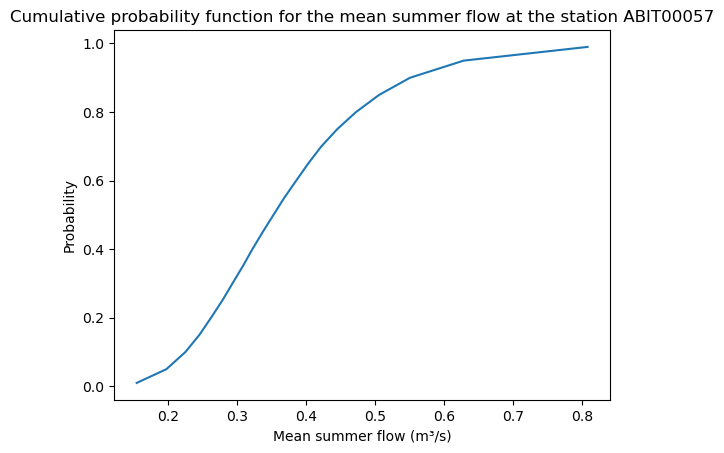

In [118]:
import matplotlib.pyplot as plt

plt.plot(ref.QMOYEA.isel(station=0), ref.QMOYEA.percentile / 100)
plt.xlabel("Mean summer flow (m³/s)")
plt.ylabel("Probability")
plt.title("Cumulative probability function for the mean summer flow at the station ABIT00057")

The methodology remains mostly the same, with the exception that the historical reference values can't easily be combined to the future deltas due to their probabilistic nature. Instead, `perturbed_indicators` should be called to perform that step.

That function will:

1. Sample 'n' values from the historical distribution, weighting the percentiles by their associated coverage.
2. Sample 'n' values from the delta distribution, using the provided weights.
3. Create the future distribution by applying the sampled deltas to the sampled historical distribution, element-wise.
4. Compute the percentiles of the future distribution.

In [220]:
# Variables should have the same name between both datasets
ref = ref.rename({"QMOYEA": "qmoyea"})

# Compute the perturbed indicators
n = 1500
fut_pct, hist_dist, delta_dist, fut_dist = xh.cc.perturbed_indicators(ref, 
                                                                      deltas=xclim.ensembles.create_ensemble(ds_dict_deltas), 
                                                                      delta_type="percentage",
                                                                      delta_weights=weights,
                                                                      n=n, 
                                                                      seed=42,  # to control the randomness
                                                                      return_dist=True)  # whether to return only the future percentiles or also return all distributions

Text(0.5, 1.0, 'Comparison of CDFs between input data and random sample')

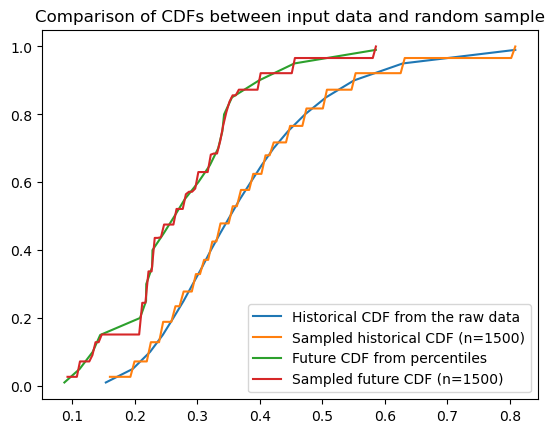

In [262]:
# Plot CDFs
def _make_cdf(ds, bins):
    count, bins_count = np.histogram(ds.qmoyea.isel(station=0), bins=bins) 
    pdf = count / sum(count) 
    return bins_count, np.cumsum(pdf) 
  
# plotting
plt.plot(ref.qmoyea.isel(station=0), ref.percentile / 100, label="Historical CDF from the raw data")
bc, c = _make_cdf(hist_dist, bins=100)
plt.plot(bc[1:], c, label=f"Sampled historical CDF (n={n})") 

plt.plot(fut_pct.qmoyea.isel(station=0, time=-1), fut_pct.percentile / 100, label="Future CDF from percentiles")
bc, c = _make_cdf(fut_dist.isel(time=-1), bins=100)
plt.plot(bc[1:], c, label=f"Sampled future CDF (n={n})") 

plt.legend() 
plt.title("Comparison of CDFs between input data and random sample")

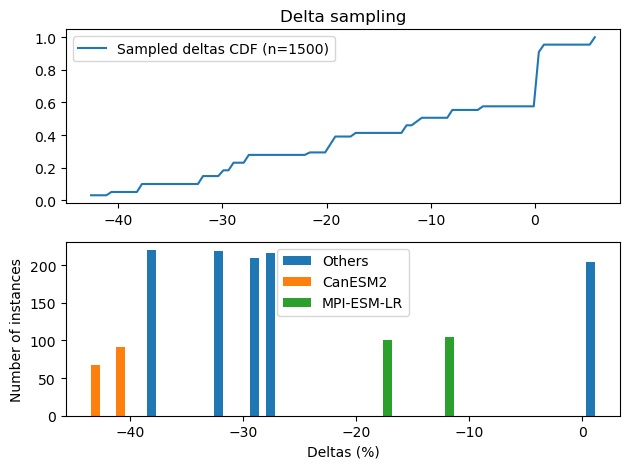

In [261]:
# Plot #2
plt.subplot(2, 1, 1)
bc, c = _make_cdf(delta_dist, bins=100)
plt.plot(bc[1:], c, label=f"Sampled deltas CDF (n={n})") 

plt.legend() 
plt.title("Delta sampling")

# Plot #3
plt.subplot(2, 1, 2)
uniquen = np.unique(delta_dist.qmoyea.isel(station=0, time=-1), return_counts=True)
plt.bar(uniquen[0], uniquen[1], label="Others")
plt.bar(uniquen[0][0:3], uniquen[1][0:3], label="CanESM2")
plt.bar(uniquen[0][7:9], uniquen[1][7:9], label="MPI-ESM-LR")
plt.legend() 
plt.ylabel("Number of instances")
plt.xlabel("Deltas (%)")

plt.tight_layout()

Text(0, 0.5, 'Mean summer flow (m³/s)')

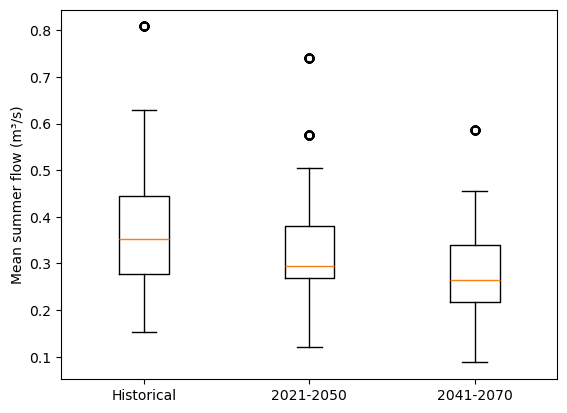

In [254]:
plt.boxplot([hist_dist.qmoyea.isel(station=0), 
             fut_dist.qmoyea.isel(station=0, time=1), 
             fut_dist.qmoyea.isel(station=0, time=2)], 
             labels=["Historical", "2021-2050", "2041-2070"])
plt.ylabel("Mean summer flow (m³/s)")

In [224]:
# The same statistics as before can also be computed by using delta_dist
delta_dist = delta_dist.rename({"sample": "realization"})  # xclim compatibility
ens_stats_2 = xh.cc.ensemble_stats(delta_dist, statistics)

# Interquartile range
ens_stats_2["qmoyea_iqr"] = ens_stats_2["qmoyea"].sel(percentiles=75) - ens_stats_2["qmoyea"].sel(percentiles=25)

# Categories of agreement on the sign of change
ens_stats_2["qmoyea_robustness_categories"] = robustness_categories(changed_or_fractions=ens_stats_2["qmoyea_changed"],
                                                                    agree=ens_stats_2["qmoyea_positive"], categories=categories, thresholds=thresholds, ops=ops)

ens_stats_2

INFO:xscen.ensembles:Calculating ensemble_percentiles from an ensemble of 1500 simulations.
INFO:xscen.ensembles:Calculating robustness_fractions from an ensemble of 1500 simulations.


<xarray.Dataset>
Dimensions:                       (station: 2, time: 3, percentiles: 5)
Coordinates:
    lat                           (station) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    lon                           (station) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    drainage_area                 (station) float32 dask.array<chunksize=(2,), meta=np.ndarray>
  * station                       (station) object 'ABIT00057' 'ABIT00058'
    horizon                       (time) <U9 dask.array<chunksize=(3,), meta=np.ndarray>
  * time                          (time) datetime64[ns] 1981-01-01 ... 2041-0...
  * percentiles                   (percentiles) int64 10 25 50 75 90
Data variables:
    qmoyea                        (time, station, percentiles) float32 dask.array<chunksize=(3, 2, 5), meta=np.ndarray>
    qmoyea_changed                (time, station) float64 dask.array<chunksize=(3, 2), meta=np.ndarray>
    qmoyea_positive               (time, station) float64 dask.array<chunksize=(3, 2), meta=np.ndarray>
    qmoyea_changed_positive       (time, station) float64 dask.array<chunksize=(3, 2), meta=np.ndarray>
    qmoyea_valid                  (time, station) float64 dask.array<chunksize=(3, 2), meta=np.ndarray>
    qmoyea_agree                  (time, station) float64 dask.array<chunksize=(3, 2), meta=np.ndarray>
    qmoyea_iqr                    (time, station) float32 dask.array<chunksize=(3, 2), meta=np.ndarray>
    qmoyea_robustness_categories  (time, station) int64 dask.array<chunksize=(3, 2), meta=np.ndarray>
Attributes: (12/45)
    institution:                    DEH (Direction de l'Expertise Hydrique)
    institute_id:                   DEH
    contact:                        atlas.hydroclimatique@environnement.gouv....
    date_created:                   2020-05-23
    featureType:                    timeSeries
    cdm_data_type:                  station
    ...                             ...
    cat:experiment:                 rcp85
    cat:member:                     r1i1p1
    cat:frequency:                  yr
    cat:xrfreq:                     AS-JAN
    cat:variable:                   ('qmoyea',)
    ensemble_size:                  1

In [225]:
# Comparison of both approaches
display(ens_stats["qmoyea_robustness_categories"].isel(station=0).to_dataframe())
display(ens_stats_2["qmoyea_robustness_categories"].isel(station=0).to_dataframe())

,lat,lon,drainage_area,station,horizon,percentile,realization,qmoyea_robustness_categories
time,,,,,,,,
1981-01-01,49.529999,-77.050003,60.759998,ABIT00057,1981-2010,50.0,A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...,3
2021-01-01,49.529999,-77.050003,60.759998,ABIT00057,2021-2050,50.0,A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...,4
2041-01-01,49.529999,-77.050003,60.759998,ABIT00057,2041-2070,50.0,A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...,4


,lat,lon,drainage_area,station,horizon,qmoyea_robustness_categories
time,,,,,,
1981-01-01,49.529999,-77.050003,60.759998,ABIT00057,1981-2010,3
2021-01-01,49.529999,-77.050003,60.759998,ABIT00057,2021-2050,4
2041-01-01,49.529999,-77.050003,60.759998,ABIT00057,2041-2070,4


In [226]:
display(ens_stats["qmoyea"].isel(station=0).to_dataframe(dim_order=["time", "percentiles"]))
display(ens_stats_2["qmoyea"].isel(station=0).to_dataframe(dim_order=["time", "percentiles"]))

lat        lon  drainage_area    station  \
time       percentiles                                                   
1981-01-01 10           49.529999 -77.050003      60.759998  ABIT00057   
           25           49.529999 -77.050003      60.759998  ABIT00057   
           50           49.529999 -77.050003      60.759998  ABIT00057   
           75           49.529999 -77.050003      60.759998  ABIT00057   
           90           49.529999 -77.050003      60.759998  ABIT00057   
2021-01-01 10           49.529999 -77.050003      60.759998  ABIT00057   
           25           49.529999 -77.050003      60.759998  ABIT00057   
           50           49.529999 -77.050003      60.759998  ABIT00057   
           75           49.529999 -77.050003      60.759998  ABIT00057   
           90           49.529999 -77.050003      60.759998  ABIT00057   
2041-01-01 10           49.529999 -77.050003      60.759998  ABIT00057   
           25           49.529999 -77.050003      60.759998  ABIT00057   
           50           49.529999 -77.050003      60.759998  ABIT00057   
           75           49.529999 -77.050003      60.759998  ABIT00057   
           90           49.529999 -77.050003      60.759998  ABIT00057   

                          horizon  percentile  \
time       percentiles                          
1981-01-01 10           1981-2010        50.0   
           25           1981-2010        50.0   
           50           1981-2010        50.0   
           75           1981-2010        50.0   
           90           1981-2010        50.0   
2021-01-01 10           2021-2050        50.0   
           25           2021-2050        50.0   
           50           2021-2050        50.0   
           75           2021-2050        50.0   
           90           2021-2050        50.0   
2041-01-01 10           2041-2070        50.0   
           25           2041-2070        50.0   
           50           2041-2070        50.0   
           75           2041-2070        50.0   
           90           2041-2070        50.0   

                                                              realization  \
time       percentiles                                                      
1981-01-01 10           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           25           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           50           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           75           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           90           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
2021-01-01 10           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           25           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           50           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           75           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           90           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
2041-01-01 10           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           25           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           50           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           75           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   
           90           A20_HYDREP_QCMERI_XXX_DEBITJ_HIS_XXX_XXX_XXX_X...   

                           qmoyea  
time       percentiles             
1981-01-01 10            0.000000  
           25            0.000000  
           50            0.000000  
           75            0.000000  
           90            0.000000  
2021-01-01 10          -21.322693  
           25          -19.629171  
           50          -12.722197  
           75           -8.304506  
           90           -0.225540  
2041-01-01 10          -39.496608  
           25          -35.445374  
           50          -29.021156  
           75          -21.885305  
           90           -6.027365

lat        lon  drainage_area    station  \
time       percentiles                                                   
1981-01-01 10           49.529999 -77.050003      60.759998  ABIT00057   
           25           49.529999 -77.050003      60.759998  ABIT00057   
           50           49.529999 -77.050003      60.759998  ABIT00057   
           75           49.529999 -77.050003      60.759998  ABIT00057   
           90           49.529999 -77.050003      60.759998  ABIT00057   
2021-01-01 10           49.529999 -77.050003      60.759998  ABIT00057   
           25           49.529999 -77.050003      60.759998  ABIT00057   
           50           49.529999 -77.050003      60.759998  ABIT00057   
           75           49.529999 -77.050003      60.759998  ABIT00057   
           90           49.529999 -77.050003      60.759998  ABIT00057   
2041-01-01 10           49.529999 -77.050003      60.759998  ABIT00057   
           25           49.529999 -77.050003      60.759998  ABIT00057   
           50           49.529999 -77.050003      60.759998  ABIT00057   
           75           49.529999 -77.050003      60.759998  ABIT00057   
           90           49.529999 -77.050003      60.759998  ABIT00057   

                          horizon     qmoyea  
time       percentiles                        
1981-01-01 10           1981-2010   0.000000  
           25           1981-2010   0.000000  
           50           1981-2010   0.000000  
           75           1981-2010   0.000000  
           90           1981-2010   0.000000  
2021-01-01 10           2021-2050 -30.004627  
           25           2021-2050 -19.845535  
           50           2021-2050 -12.722197  
           75           2021-2050  -8.304506  
           90           2021-2050   5.739326  
2041-01-01 10           2041-2070 -40.848972  
           25           2041-2070 -38.098923  
           50           2041-2070 -29.021156  
           75           2041-2070 -17.236677  
           90           2041-2070   0.700776